$$ \mathbf{g}_t \leftarrow \nabla f_{\mathcal{B}_t} (x_{t-1}) = \frac{1}{\vert\mathcal{B}\vert}\sum_{i\in \mathcal{B}_t} \nabla f_i(x_{t-1}) $$

$$ x_t \leftarrow x_{t-1} - \eta_t\mathbf{g}_t $$

In [1]:
%matplotlib inline
import MyD2l as d2l
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from pathlib import Path
def get_data_ch7():
    data = np.genfromtxt(Path('deep learning/data/airfoil_self_noise.dat'), delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1]), torch.tensor(data[:1500, -1])

features, labels = get_data_ch7()
features = features.type(torch.float)
labels = labels.type(torch.float)
features.shape

torch.Size([1500, 5])

## classical code

In [3]:
def sgd(params, states, hyperparams):
    for p in params:
        p -= hyperparams['lr'] * p.grad
        p.grad.zero_()

In [4]:
def train_ch7(trainer_fn, states, hyperparms, features, labels,
              batch_size=10, num_epochs=2):
    net, loss = d2l.linreg, d2l.square_loss
    w = torch.normal(torch.zeros(features.shape[1], 1), 0.01)
    b = torch.zeros(1)
    w.requires_grad_(True)
    b.requires_grad_(True)
    
    def eval_loss():
        return loss(net(features, w, b), labels).item()
    
    ls = [eval_loss()]
    data_iter = DataLoader(
        TensorDataset(features, labels), batch_size, shuffle=True, num_workers=4)
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y)
            l.backward()
            with torch.no_grad():
                trainer_fn([w, b], states, hyperparms)
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.245631, 1.158639 sec per epoch


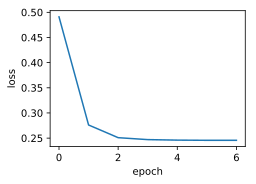

In [5]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

loss: 0.244155, 1.686502 sec per epoch


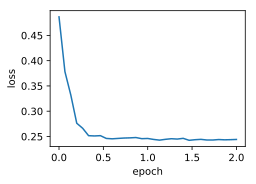

In [6]:
train_sgd(0.005, 1)

loss: 0.243833, 0.848238 sec per epoch


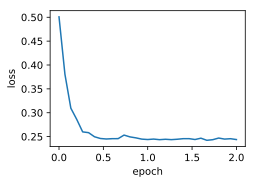

In [7]:
train_sgd(0.05, 10)

## brief code

In [17]:
def train_nn_ch7(trainer_hyperparams, features, labels,
                 batch_size=10, num_epochs=2):
    net = nn.Linear(5, 1)
    loss = nn.MSELoss()
    
    def eval_loss():
        return loss(net(features), labels.view(-1, 1)).item()
    
    ls = [eval_loss()]
    data_iter = DataLoader(
        TensorDataset(features, labels), batch_size, shuffle=True, num_workers=4)
    trainer = torch.optim.SGD(net.parameters(), trainer_hyperparams['lr'])
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X), y.view(-1, 1))
            l.backward()
            trainer.step()
            trainer.zero_grad()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
        for param_group in trainer.param_groups:
            param_group['lr'] *= 0.1
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.492950, 1.115149 sec per epoch


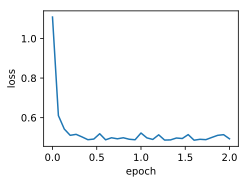

In [14]:
train_nn_ch7({'lr': 0.05}, features, labels, 10)

loss: 0.496341, 1.294198 sec per epoch


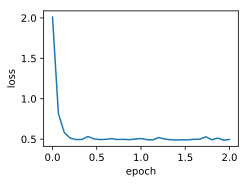

In [16]:
train_nn_ch7({'lr': 0.05}, features, labels, 10)

loss: 0.484237, 1.199100 sec per epoch


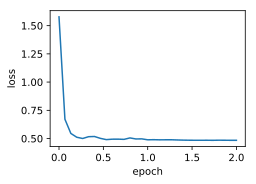

In [18]:
train_nn_ch7({'lr': 0.05}, features, labels, 10)
